The idea behind this notebook series is to go slow and build a solid understanding of code and maths involved in deep learning. Few points to note -
1. For simplicity of calculations, I have used small integer values in examples
2. This code is only for understanding the concepts so it is missing couple of things like type checking and error handling

This is the 2<sup>nd</sup> notebook in the series. Here we build upon the content of 1st Notebook and build understanding of backpropagation and gradient descent. 

This time, I have also added the code to validate our learnings and implementations against PyTorch. There is one major difference is that PyTorch uses row vector for representing weights, inputs and outputs whereas we have been using column vector. This doesn't impact much just at the initialization we need to transpose our vectors before feeding into pytorch networks.

[Colab link](https://colab.research.google.com/github/shwetaAgrawal/deeplearning_tutorials/blob/main/notebooks/2_Intro_to_backpropagation.ipynb)


In [1]:
# Pre-requisite for running this notebook - numpy. If you come across error "No module named 'numpy'" then please uncomment the below line and run this cell
#!pip install numpy torch

# Introduction to Backpropagation

*Backpropagation*, short for "backward propagation of errors," is a fundamental algorithm used in training artificial neural networks. 

Neural network training can be divided into two phases:
1. Forward Pass: During the forward pass, the input data is passed through the network layer by layer to generate an output. Already covered in 1st notebook in the series.
2. Backward Pass: In the backward pass, we compare the predicted output and actual output to compute the error. The error is then propagated back through the network. We will cover this in detail in this notebook.

Steps in Backpropagation:
1. Compute Error: Calculate the error between the predicted output and the actual target values using a loss function (e.g., Mean Squared Error, Cross-Entropy Loss).
2. Compute Gradient: Compute the gradients of the error with respect to each weight using the chain rule.
3. Update Weights: Adjust the weights and biases using the computed gradients and an optimization algorithm.

If you want to do it by hand before jumping into the code, check [this workbook](https://aibyhand.substack.com/p/7-can-you-calculate-a-transformer) published by Tom Yeh.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim

# Importing the custom modules. these are available in repo - https://github.com/shwetaAgrawal/deeplearning_tutorials/tree/main/notebooks
from ann_module import ActivationFunctions
from ann_module import NeuralNetworkForwardPass
from utils import SampleInputOutputUtils

## Backpropagation for single neuron
Just like what we did in 1st notebook, we'll start with a very simple example. 

To recap, our single neuron's calculation
$$
\hat y = f(W^T \cdot x + b)
$$
where ${f}$ is the activation function, ${W^T}$ is weight matrix and ${b}$ is the bias vector 


Now we need to define the following: 
1. Error - It is defined as difference between actual and predicted output - $(y - \hat y)$
2. Loss function (${L}$) - Lets use mean squared error as loss function which is calculated as 
$$
L = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
Where:
- $y_i$ is the actual output for i<sup>th</sup> input.
- $\hat{y}_i$ is the predicted output for i<sup>th</sup> input.
3. Gradient ($\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$) - These are partial derivatives ${L}$ with respect to w and b. 
4. Learning rate (**η**) - Learning rate is used to tweak update magnitude, it takes value from (0, 1]. High learning rate leads to larger weight updates and increases the chance of missing global minima and weights not coverging. Small learning rate leads to smaller weight updates and increases the chance of being stuck in local minima and increased training time. 
$$
W = W - η \cdot \frac{\partial L}{\partial w}
$$
$$
b = b - η \cdot \frac{\partial L}{\partial b}
$$

### Loss Calculation

In [3]:
def computeLoss(y: np.ndarray, y_pred: np.ndarray) -> float:
    """
    This function computes the loss between the predicted value and the actual value.
    Args:
    """
    if y is None or y_pred is None or y.size == 0 or y_pred.size == 0:
        raise ValueError("y and y_pred cannot be None/empty")
    
    if y.size != y_pred.size:
        raise ValueError("y and y_pred should be of same length")
    
    return np.mean((y - y_pred) ** 2) 

In [4]:
y = np.random.randint(-1, 1, 5)
y_pred = np.random.randint(-1, 1, 5)

print("\nActual: ", y)
print("\nPredicted: ", y_pred)
print("\nLoss: ", computeLoss(y, y_pred))


Actual:  [-1 -1  0 -1 -1]

Predicted:  [ 0 -1 -1  0 -1]

Loss:  0.6


In [5]:
# validate the loss using PyTorch
criterion = nn.MSELoss()
loss = criterion(torch.tensor(y_pred, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
print("\nLoss using PyTorch: ", loss)

assert(loss == computeLoss(y, y_pred))


Loss using PyTorch:  tensor(0.6000)


### Gradient Calculation

To start with calculate loss and its derivative for 1 sample i.e our dataset consists of only 1 record and thus has one 1 pair of $y$ and $\hat{y}$ - 
$$
L =  (y - \hat{y})^2
$$

$\hat{y}$ is a function of $w$ and $b$ as shared earlier, so we can substitute $\hat{y}$ in loss function with that - 
$$
L = (y - (W^T \cdot x + b))^2
$$

As since w and b are independent variables and not impacted by each other, so 
$$
\frac{\partial w}{\partial b} = \frac{\partial b}{\partial w} = 0
$$

#### Gradient for weight updation 
Now we are going to calculate partial derivative of substituted loss function wrt ${w}$ -
$$
\frac{\partial L}{\partial W} = \frac{\partial}{\partial W} (y - (W^T \cdot x + b))^2
$$

Applying the chain rule:
$$
\frac{\partial L}{\partial W} = 2 (y -(W^T \cdot x + b)) \cdot \frac{\partial}{\partial W} (y - (W^T \cdot x + b))
$$

Differentiating the inner term (since $y$ is a constant and $\frac{\partial b}{\partial W}$ = 0):
$$
\frac{\partial}{\partial W} (y - (W^T \cdot x + b)) = -x
$$

Combining the results:
$$
\frac{\partial L}{\partial W} = 2 (y - (W^T \cdot x + b)) \cdot (-x) = -2x (y - (W^T \cdot x + b)) = -2x(y - \hat{y})
$$

Now, we can extend above equation to multiple record dataset by taking average of these individual sample derivatives:
$$
\frac{\partial L}{\partial W} = -\frac{2}{n} \sum_{i=1}^{n}x_i(y_i - \hat{y}_i))
$$

In [6]:
# lets write down the gradient calculation function now
def computeWeightGradient(y: np.ndarray, y_pred: np.ndarray, x_input: np.ndarray) -> np.ndarray:
    """
    This function computes the gradient of the loss function with respect to the predicted value.
    Args:
    """
    if y is None or y_pred is None or x_input is None or y.size == 0 or y_pred.size == 0 or x_input.size == 0:
        raise ValueError("y and y_pred cannot be None/empty")
    
    if y.size != y_pred.size:
        raise ValueError("y, y_pred should be of same length")
    if y.size != x_input.shape[-1]:
        raise ValueError("y and x_input should have same number of records")
    
    # we want element wise multiplication of the two arrays here because for a batch of inputs, 
    # we are multiplying each input with the corresponding error
    axis_avg = (x_input.ndim - 1) if x_input.ndim > 1 else None #last axis represents batch of inputs and we want to average over the batch
    return -2 * np.mean((y - y_pred) * x_input, axis=axis_avg, keepdims=True) 

#### Gradient for bias updation
Similarly we can calculate gradient for bias. 
$$
\frac{\partial L}{\partial b} = \frac{\partial}{\partial b} (y - (W^T \cdot x + b))^2
$$

Applying chain rule, we get:
$$
\frac{\partial L}{\partial b} = 2 (y -(W^T \cdot x + b)) \cdot \frac{\partial}{\partial b} (y - (W^T \cdot x + b))
$$

Differentiating the inner term (since $y$ is a constant and $\frac{\partial w}{\partial b}$ = 0):
$$
\frac{\partial}{\partial b} (y - (W^T \cdot x + b)) = -1
$$

Combining the results:
$$
\frac{\partial L}{\partial b} = 2 (y - (W^T \cdot x + b)) \cdot (-1) = 2(y - (W^T \cdot x + b)) = -2(y - \hat{y})
$$

Now, we can extend above equation to multiple record dataset by taking average of these individual sample derivatives:
$$
\frac{\partial L}{\partial b} = \frac{-2}{n} \sum_{i=1}^{n}(y_i - \hat{y}_i)
$$

In [7]:
# lets write down the gradient calculation function now
def computeBiasGradient(y: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """
    This function computes the gradient of the loss function with respect to the predicted value.
    Args:
    """
    if y is None or y_pred is None or y.size == 0 or y_pred.size == 0:
        raise ValueError("y and y_pred cannot be None/empty")
    
    if y.size != y_pred.size:
        raise ValueError("y and y_pred should be of same length")
    
    return -2 * np.mean(y - y_pred)

In [8]:
# lets generate some sample inputs and outputs

# We'll start with one input and output dimension & a simpler network of just 1 layer mapping input to output
input_dimensions = 1
output_dimensions = 1 
batch_size = 5
input_generator = SampleInputOutputUtils(input_dimensions, output_dimensions)
x_input, y = input_generator.getSampleInputOutputBatch(batch_size)

print("\nInput: \n", x_input)
print("\nTarget output: ", y)

# lets initialize our basic neural network with just 1 layer mapping inputs to outputs
nn_custom = NeuralNetworkForwardPass(input_dimensions, output_dimensions, ActivationFunctions.linear, [])

# For debugging purposes, lets print the weights and bias of the network
print("\nWeights: ", nn_custom.layers[0].weights)
print("\nBias: ", nn_custom.layers[0].bias)


Input: 
 [[4 0 0 1 0]]

Target output:  [[1 0 0 1 0]]

Weights:  [[-1]]

Bias:  [[0]]


In [9]:
y_pred = nn_custom.forward(x_input)

print("\nPredicted output: ", y_pred)
print("\nLoss: ", computeLoss(y, y_pred))

print("\nWeight Gradient: ", computeWeightGradient(y, y_pred, x_input))
print("\nBias Gradient: ", computeBiasGradient(y, y_pred))

# storing these for validation with PyTorch
w0, b0 = nn_custom.layers[0].weights, nn_custom.layers[0].bias
w0_grad, b0_grad = computeWeightGradient(y, y_pred, x_input), computeBiasGradient(y, y_pred)

# lets update the weights using the gradients
learning_rate = 0.1
nn_custom.layers[0].weights = nn_custom.layers[0].weights - learning_rate * w0_grad
print("\nUpdated Weights: ", nn_custom.layers[0].weights)

# lets update the bias using the gradients
nn_custom.layers[0].bias = nn_custom.layers[0].bias - learning_rate * b0_grad
print("\nUpdated Bias: ", nn_custom.layers[0].bias)


Predicted output:  [[-4  0  0 -1  0]]

Loss:  5.8

Weight Gradient:  [[-8.8]]

Bias Gradient:  -2.8

Updated Weights:  [[-0.12]]

Updated Bias:  [[0.28]]


In [10]:
# validate above gradient calculations using PyTorch

# lets convert the numpy arrays to torch tensors
# pytorch uses row vectors instead of column vectors, so we need to transpose everything, input, output, weights and bias
x_input_torch = torch.tensor(x_input.T, dtype=torch.float32)
y_torch = torch.tensor(y.T, dtype=torch.float32)

# lets initialize our basic neural network with just 1 layer mapping inputs to outputs
nn_torch = nn.Linear(input_dimensions, output_dimensions, bias=True)
nn_torch.weight.data = torch.tensor(w0.T, dtype=torch.float32)
nn_torch.bias.data = torch.tensor(b0.T, dtype=torch.float32)

y_pred_torch = nn_torch(x_input_torch)
print("\nPredicted output using PyTorch: ", y_pred_torch)
assert(np.allclose(y_pred, y_pred_torch.detach().numpy().T))

# lets compute the loss using PyTorch
criterion = nn.MSELoss()
loss = criterion(y_pred_torch, y_torch)
print("\nLoss using PyTorch: ", loss)
assert(loss == computeLoss(y, y_pred))

optimizer = optim.SGD(nn_torch.parameters(), lr=0.1)
# lets compute the gradients using PyTorch
optimizer.zero_grad()
loss.backward()

print("\nWeight Gradient using PyTorch: ", nn_torch.weight.grad)
assert(np.allclose(w0_grad, nn_torch.weight.grad.detach().numpy()))

print("\nBias Gradient using PyTorch: ", nn_torch.bias.grad)
assert(np.allclose(b0_grad, nn_torch.bias.grad.detach().numpy()))

# lets update the weights using pytorch
optimizer.step()
print("\nUpdated Weights using PyTorch: ", nn_torch.weight.data)
print("\nUpdated Bias using PyTorch: ", nn_torch.bias.data)
assert(np.allclose(nn_custom.layers[0].weights, nn_torch.weight.data.detach().numpy()))
assert(np.allclose(nn_custom.layers[0].bias, nn_torch.bias.data.detach().numpy()))


Predicted output using PyTorch:  tensor([[-4.],
        [ 0.],
        [ 0.],
        [-1.],
        [ 0.]], grad_fn=<AddmmBackward0>)

Loss using PyTorch:  tensor(5.8000, grad_fn=<MseLossBackward0>)

Weight Gradient using PyTorch:  tensor([[-8.8000]])

Bias Gradient using PyTorch:  tensor([[-2.8000]])

Updated Weights using PyTorch:  tensor([[-0.1200]])

Updated Bias using PyTorch:  tensor([[0.2800]])


In [11]:
# lets write a simple training loop to train the network using above weight and bias update rules
def fit(nn: NeuralNetworkForwardPass, x_input: np.ndarray, y: np.ndarray, learning_rate: float, epochs: int) -> None:
    """
    This function trains the neural network using the given inputs and outputs.
    Args:
        nn: NeuralNetworkForwardPass object - The neural network to be trained
        x_input: np.ndarray - The input data
        y: np.ndarray - The target output data
        learning_rate: float - The learning rate to be used for training
        epochs: int - The number of epochs to train the network
    """

    loss_arr = np.zeros(epochs)
    for epoch in range(epochs):
        y_pred = nn.forward(x_input)
        loss = computeLoss(y, y_pred)
        loss_arr[epoch] = loss
        print("Epoch: ", epoch, " Loss: ", loss)

        # Compute the gradients
        weight_gradient = computeWeightGradient(y, y_pred, x_input)
        bias_gradient = computeBiasGradient(y, y_pred)

        # Update the weights and bias
        nn.layers[0].weights = nn.layers[0].weights - learning_rate * weight_gradient
        nn.layers[0].bias = nn.layers[0].bias - learning_rate * bias_gradient
    return loss_arr

In [12]:
loss_arr = fit(nn_custom, x_input, y, 0.1, 100)

Epoch:  0  Loss:  0.4761599999999997
Epoch:  1  Loss:  0.14117222399999999
Epoch:  2  Loss:  0.11406735605759999
Epoch:  3  Loss:  0.10740550233882624
Epoch:  4  Loss:  0.10319139855922732
Epoch:  5  Loss:  0.10003653505798826
Epoch:  6  Loss:  0.09763858854051023
Epoch:  7  Loss:  0.09581371063605011
Epoch:  8  Loss:  0.09442480964014158
Epoch:  9  Loss:  0.09336771896461687
Epoch:  10  Loss:  0.09256316815793046
Epoch:  11  Loss:  0.09195082519706886
Epoch:  12  Loss:  0.09148477146849301
Epoch:  13  Loss:  0.09113005835529422
Epoch:  14  Loss:  0.09086008649375994
Epoch:  15  Loss:  0.09065461112984356
Epoch:  16  Loss:  0.09049822399773047
Epoch:  17  Loss:  0.09037919787885958
Epoch:  18  Loss:  0.090288607196736
Epoch:  19  Loss:  0.09021965870235962
Epoch:  20  Loss:  0.09016718205944962
Epoch:  21  Loss:  0.0901272421292741
Epoch:  22  Loss:  0.09009684388094932
Epoch:  23  Loss:  0.09007370779890933
Epoch:  24  Loss:  0.09005609894571345
Epoch:  25  Loss:  0.09004269686188883


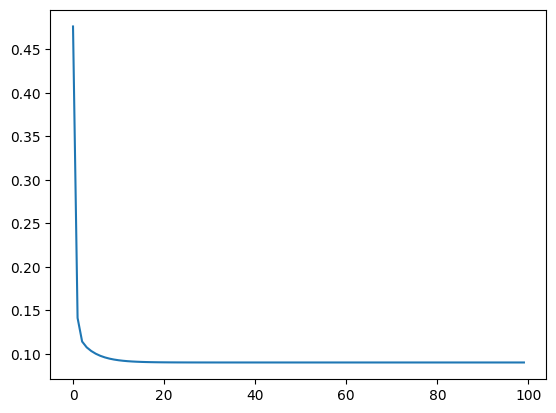

In [13]:
# run cell 7 onwards multiple times to be able to see training loss variations for different inputs and outputs
# training loss follows a U-curve and usually we select the weights and bias corresponding to least loss
plt.plot(loss_arr)

In [14]:
# validate the training using PyTorch
loss_torch = np.zeros(100)
for epoch in range(100):
    optimizer.zero_grad()
    y_pred_torch = nn_torch(x_input_torch)
    loss = criterion(y_pred_torch, y_torch)
    loss.backward()
    optimizer.step()
    print("Epoch: ", epoch, " Loss: ", loss)
    loss_torch[epoch] = loss

assert(loss_arr[-1].round(1) == loss_torch[-1].round(1))
assert(np.allclose(nn_custom.layers[0].weights, nn_torch.weight.data.detach().numpy()))
assert(np.allclose(nn_custom.layers[0].bias, nn_torch.bias.data.detach().numpy()))

Epoch:  0  Loss:  tensor(0.4762, grad_fn=<MseLossBackward0>)
Epoch:  1  Loss:  tensor(0.1412, grad_fn=<MseLossBackward0>)
Epoch:  2  Loss:  tensor(0.1141, grad_fn=<MseLossBackward0>)
Epoch:  3  Loss:  tensor(0.1074, grad_fn=<MseLossBackward0>)
Epoch:  4  Loss:  tensor(0.1032, grad_fn=<MseLossBackward0>)
Epoch:  5  Loss:  tensor(0.1000, grad_fn=<MseLossBackward0>)
Epoch:  6  Loss:  tensor(0.0976, grad_fn=<MseLossBackward0>)
Epoch:  7  Loss:  tensor(0.0958, grad_fn=<MseLossBackward0>)
Epoch:  8  Loss:  tensor(0.0944, grad_fn=<MseLossBackward0>)
Epoch:  9  Loss:  tensor(0.0934, grad_fn=<MseLossBackward0>)
Epoch:  10  Loss:  tensor(0.0926, grad_fn=<MseLossBackward0>)
Epoch:  11  Loss:  tensor(0.0920, grad_fn=<MseLossBackward0>)
Epoch:  12  Loss:  tensor(0.0915, grad_fn=<MseLossBackward0>)
Epoch:  13  Loss:  tensor(0.0911, grad_fn=<MseLossBackward0>)
Epoch:  14  Loss:  tensor(0.0909, grad_fn=<MseLossBackward0>)
Epoch:  15  Loss:  tensor(0.0907, grad_fn=<MseLossBackward0>)
Epoch:  16  Loss: 

#### Multi-dimensional Input


Input: 
 [[3 2 4 1 2]
 [1 1 2 2 4]]

Target output:  [[1 0 0 0 0]]

Weights:  [[1]
 [0]]

Bias:  [[0]]

Predicted output:  [[3 2 4 1 2]]

Loss:  5.8

Weight Gradient:  [[12.4]
 [ 8.8]]

Bias Gradient:  4.4

Updated Weights:  [[-0.24]
 [-0.88]]

Updated Bias:  [[-0.44]]
Epoch:  0  Loss:  9.626880000000005
Epoch:  1  Loss:  16.436204544000013
Epoch:  2  Loss:  28.353555010355212
Epoch:  3  Loss:  49.10605875165269
Epoch:  4  Loss:  85.18771639976873
Epoch:  5  Loss:  147.8913444904052
Epoch:  6  Loss:  256.8428624041216
Epoch:  7  Loss:  446.14401094684763
Epoch:  8  Loss:  775.0460963353449
Epoch:  9  Loss:  1346.4956010401281

Final Weights:  [[-10.23828678]
 [ -8.85523052]]

Final Bias:  [[-4.13774005]]


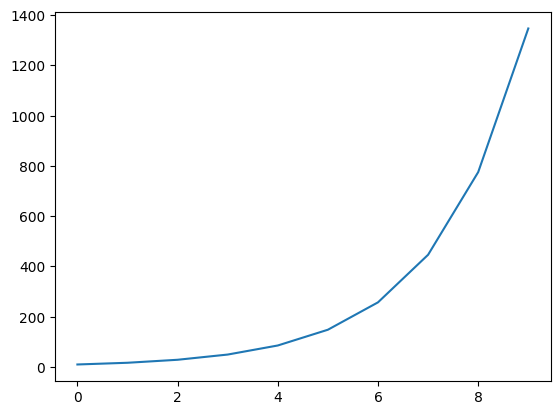

In [15]:
# lets increase the complexity of the network by having multi-dimensional inputs
# first test if our existing code works for multi-dimensional inputs

# lets generate some sample inputs and outputs
# We'll start with 2-D input and 1-D output & a simpler network of just 1 layer mapping input to output
input_dimensions = 2
output_dimensions = 1 
input_generator = SampleInputOutputUtils(input_dimensions, output_dimensions)
x_input, y = input_generator.getSampleInputOutputBatch(5)

print("\nInput: \n", x_input)
print("\nTarget output: ", y)

# lets initialize our basic neural network with just 1 layer mapping inputs to outputs
nn_custom = NeuralNetworkForwardPass(input_dimensions, output_dimensions, ActivationFunctions.linear, [])

# For debugging purposes, lets print the weights and bias of the network
print("\nWeights: ", nn_custom.layers[0].weights)
print("\nBias: ", nn_custom.layers[0].bias)

y_pred = nn_custom.forward(x_input)

print("\nPredicted output: ", y_pred)
print("\nLoss: ", computeLoss(y, y_pred))

print("\nWeight Gradient: ", computeWeightGradient(y, y_pred, x_input))
print("\nBias Gradient: ", computeBiasGradient(y, y_pred))

w0, b0 = nn_custom.layers[0].weights, nn_custom.layers[0].bias
w0_grad, b0_grad = computeWeightGradient(y, y_pred, x_input), computeBiasGradient(y, y_pred)
# lets update the weights using the gradients
learning_rate = 0.1
nn_custom.layers[0].weights = nn_custom.layers[0].weights - learning_rate * w0_grad
print("\nUpdated Weights: ", nn_custom.layers[0].weights)

# lets update the bias using the gradients
nn_custom.layers[0].bias = nn_custom.layers[0].bias - learning_rate * b0_grad
print("\nUpdated Bias: ", nn_custom.layers[0].bias)

loss_arr = fit(nn_custom, x_input, y, 0.1, 10)
plt.plot(loss_arr)

print("\nFinal Weights: ", nn_custom.layers[0].weights)
print("\nFinal Bias: ", nn_custom.layers[0].bias)

# so we were able to train the network with multi-dimensional inputs with our existing code

In [16]:
w0, b0

(array([[1],
        [0]]),
 array([[0]]))

In [17]:
# lets validate the training using PyTorch
# lets convert the numpy arrays to torch tensors

x_input_torch = torch.tensor(x_input.T, dtype=torch.float32)
y_torch = torch.tensor(y.T, dtype=torch.float32)

# lets initialize our basic neural network with just 1 layer mapping inputs to outputs
nn_torch = nn.Linear(input_dimensions, output_dimensions, bias=True)
nn_torch.weight.data = torch.tensor(w0.T, dtype=torch.float32) # we need to transpose the weights because of the way PyTorch initializes weights
nn_torch.bias.data = torch.tensor(b0.T, dtype=torch.float32) # we need to transpose the bias because of the way PyTorch initializes bias

optimizer = optim.SGD(nn_torch.parameters(), lr=0.1)
loss_torch = np.zeros(11)
for epoch in range(11): # we are running for 11 epochs to match the number of epochs in our custom code 10 in fit step + 1 during step by step run
    y_pred_torch = nn_torch(x_input_torch)
    loss = criterion(y_pred_torch, y_torch)
    print("Epoch: ", epoch, " Loss: ", loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_torch[epoch] = loss

assert(loss_arr[-1].round(1) == loss_torch[-1].round(1))
assert(np.allclose(nn_custom.layers[0].weights, nn_torch.weight.data.detach().numpy().T))
assert(np.allclose(nn_custom.layers[0].bias, nn_torch.bias.data.detach().numpy().T))
print("\nFinal Weights using PyTorch: ", nn_torch.weight.data)
print("\nFinal Bias using PyTorch: ", nn_torch.bias.data)

Epoch:  0  Loss:  tensor(5.8000, grad_fn=<MseLossBackward0>)
Epoch:  1  Loss:  tensor(9.6269, grad_fn=<MseLossBackward0>)
Epoch:  2  Loss:  tensor(16.4362, grad_fn=<MseLossBackward0>)
Epoch:  3  Loss:  tensor(28.3536, grad_fn=<MseLossBackward0>)
Epoch:  4  Loss:  tensor(49.1061, grad_fn=<MseLossBackward0>)
Epoch:  5  Loss:  tensor(85.1878, grad_fn=<MseLossBackward0>)
Epoch:  6  Loss:  tensor(147.8914, grad_fn=<MseLossBackward0>)
Epoch:  7  Loss:  tensor(256.8430, grad_fn=<MseLossBackward0>)
Epoch:  8  Loss:  tensor(446.1444, grad_fn=<MseLossBackward0>)
Epoch:  9  Loss:  tensor(775.0470, grad_fn=<MseLossBackward0>)
Epoch:  10  Loss:  tensor(1346.4973, grad_fn=<MseLossBackward0>)

Final Weights using PyTorch:  tensor([[-10.2383,  -8.8552]])

Final Bias using PyTorch:  tensor([[-4.1377]])


#### Training with multiple layers


In [18]:
# lets increase the complexity of the network by having multi-dimensional inputs and multi-layer network
# first test if our existing code works for multi-layer network

# lets generate some sample inputs and outputs  - 2-D input and 1-D output & a network with 2 layers
input_dimensions = 2
output_dimensions = 1
hidden_layer_neurons = 2
input_generator = SampleInputOutputUtils(input_dimensions, output_dimensions)
x_input, y = input_generator.getSampleInputOutputBatch(5)

print("\nInput: \n", x_input)
print("\nTarget output: ", y)

# lets initialize our basic neural network with 2 layers - 1 hidden layer and 1 output layer
nn_custom = NeuralNetworkForwardPass(input_dimensions, output_dimensions, ActivationFunctions.linear, [(hidden_layer_neurons, ActivationFunctions.linear)])

# For debugging purposes, lets print the weights and bias of the network
print("\nHidden Layer Weights: ", nn_custom.layers[0].weights)
print("\nHidden Layer Bias: ", nn_custom.layers[0].bias)

print("\nOutput Layer Weights: ", nn_custom.layers[1].weights)
print("\nOutput Layer Bias: ", nn_custom.layers[1].bias)

y_pred = nn_custom.forward(x_input)

print("\nPredicted output: ", y_pred)
print("\nLoss: ", computeLoss(y, y_pred))

# since input to output layer is hidden layer's output
print("\nOutput layer Weight Gradient: ", computeWeightGradient(y, y_pred, nn_custom.layers[0].forward(x_input)))
print("\nOutput layer Bias Gradient: ", computeBiasGradient(y, y_pred))

# so computation of gradient for final layer is going to be same as before and we will be able to update the weights and bias of the final layer
# however for hidden layer, we can't use the same method because its output is input to another layer which then results in final output
# so lets go back to drawing board and analyze how we can compute the gradients for hidden layer


Input: 
 [[3 3 4 3 0]
 [2 1 0 3 1]]

Target output:  [[1 1 0 0 0]]

Hidden Layer Weights:  [[ 0  0]
 [ 0 -1]]

Hidden Layer Bias:  [[0]
 [0]]

Output Layer Weights:  [[ 1]
 [-1]]

Output Layer Bias:  [[0]]

Predicted output:  [[2 1 0 3 1]]

Loss:  2.2

Output layer Weight Gradient:  [[-0. ]
 [-4.8]]

Output layer Bias Gradient:  2.0


##### Hidden Layer gradient computation
Lets represent hidden layer weights, bias & output as ${hw}$, ${hb}$, and ${h\hat y}$. And calculate relationship between ${hw}$ and ${L}$. We know that
$$
L = (y - \hat y)^2
$$

And ${\hat y}$ = ${w \cdot h\hat y + b}$ since hidden layers output is input to the output layer. And hidden layer output is a function of hidden layer weights and bias ${h\hat y}$ = ${hw \cdot x + hb}$. 

So we can see that this relationship takes form of ${f(g(x))}$ where we can think of ${g(x)}$ as output of hidden layer and ${f}$ as output of final layer. And by chain rule we can differentiate this as follows: 
$$
\frac{\partial f(g(x))}{\partial x} = \frac{\partial f(g(x))}{\partial g(x)} \cdot \frac{\partial g(x)}{\partial x}
$$

Now we are going to calculate partial derivative of loss function wrt ${hw}$ -
$$
\frac{\partial L}{\partial hw} = \frac{\partial}{\partial hw} (y - (w \cdot h\hat y + b))^2
$$

Applying the chain rule:
$$
\frac{\partial L}{\partial hw} = 2 (y -(w \cdot h\hat y + b)) \cdot \frac{\partial}{\partial h\hat y} (y - (w \cdot h\hat y + b)) \cdot \frac{\partial}{\partial hw} (h\hat y) 
$$

Differentiating the first inner term (since $y$ is a constant and $\frac{\partial b}{\partial h\hat y}$ = 0):
$$
\frac{\partial}{\partial h\hat y} (y - (w \cdot h\hat y + b)) = -w
$$

Differentiating the second inner term (since $y$ is a constant and $\frac{\partial b}{\partial h\hat y}$ = 0):
$$
\frac{\partial}{\partial hw} (h\hat y) = \frac{\partial}{\partial hw} (hw.x + hb) = x
$$

Combining the results:
$$
\frac{\partial L}{\partial hw} = 2 (y - (w \cdot h\hat y + b)) \cdot (-w) \cdot (x) = -2 w \cdot x (y - (w \cdot h\hat y + b)) = -2 w \cdot x (y - \hat{y})
$$

Now, we can extend above equation to multiple record dataset by taking average of these individual sample derivatives:
$$
\frac{\partial L}{\partial hw} = -\frac{2 \cdot w}{n} \cdot \sum_{i=1}^{n} x_i(y_i - \hat{y}_i)
$$


In [19]:
# lets write down the function to get the gradient of the loss function with respect to the hidden layer weights

def computeHiddenLayerWeightGradient(nn, y, y_pred, x_input):
    """
    This function computes the gradient of the loss function with respect to the hidden layer weights.
    Args:
        nn: NeuralNetworkForwardPass object - The neural network to be trained
        y: np.ndarray - The target output data
        y_pred: np.ndarray - The predicted output data
        x_input: np.ndarray - The input data
    """
    if y is None or y_pred is None or x_input is None or y.size == 0 or y_pred.size == 0 or x_input.size == 0:
        raise ValueError("y and y_pred cannot be None/empty")
    
    if y.size != y_pred.size:
        raise ValueError("y, y_pred should be of same length")
    if y.size != x_input.shape[-1]:
        raise ValueError("y and x_input should have same number of records")
    
    axis_avg = (x_input.ndim - 1) if x_input.ndim > 1 else None #last axis represents batch of inputs and we want to average over the batch
    
    # we need to multiply the error in the output layer with the weights of the output layer [output layer weights are updated after hidden layer weights are updated]
    # we want element wise multiplication of the two arrays here because for a batch of inputs, 
    # we are multiplying each weight * input with the corresponding error
    # we have put a transpose here because we have transposed our weight matrix during initialization itself
    return -2 * np.mean((y - y_pred) *  x_input, axis=axis_avg, keepdims=True) @ nn.layers[1].weights.T

Similarly we can compute the gradient for hidden layer bias

$$
\frac{\partial L}{\partial hb} = -\frac{2 \cdot w}{n} \cdot \sum_{i=1}^{n} (y_i - \hat{y}_i)
$$

In [20]:
def computeHiddenLayerBiasGradient(nn, y, y_pred, x_input):
    """
    This function computes the gradient of the loss function with respect to the hidden layer weights.
    Args:
        nn: NeuralNetworkForwardPass object - The neural network to be trained
        y: np.ndarray - The target output data
        y_pred: np.ndarray - The predicted output data
        x_input: np.ndarray - The input data
    """
    if y is None or y_pred is None or x_input is None or y.size == 0 or y_pred.size == 0 or x_input.size == 0:
        raise ValueError("y and y_pred cannot be None/empty")
    
    if y.size != y_pred.size:
        raise ValueError("y, y_pred should be of same length")
    
    return -2 * np.mean(y - y_pred) * np.reshape(nn.layers[1].weights, (nn.input_dimensions, 1))

In [21]:
# lets update the weights using the gradients
# we need to store hidden layer output for output layer weight update rule
w0, b0 = nn_custom.layers[0].weights, nn_custom.layers[0].bias
w1, b1 = nn_custom.layers[1].weights, nn_custom.layers[1].bias

hidden_layer_output = nn_custom.layers[0].forward(x_input)
print("\n Hidden Layer output: ", hidden_layer_output)
learning_rate = 0.1

w0_grad, b0_grad = computeHiddenLayerWeightGradient(nn_custom, y, y_pred, x_input), computeHiddenLayerBiasGradient(nn_custom, y, y_pred, x_input)
w1_grad, b1_grad = computeWeightGradient(y, y_pred, hidden_layer_output), computeBiasGradient(y, y_pred)

print("\nHidden Layer Weight gradient: ", computeHiddenLayerWeightGradient(nn_custom, y, y_pred, x_input))
print("\nHidden Layer bias gradient: ", computeHiddenLayerBiasGradient(nn_custom, y, y_pred, x_input))

nn_custom.layers[0].weights = nn_custom.layers[0].weights - learning_rate * w0_grad
nn_custom.layers[0].bias = nn_custom.layers[0].bias - learning_rate * b0_grad
print("\nUpdated Hidden Layer Weights: ", nn_custom.layers[0].weights)
print("\nUpdated Hidden Layer Bias: ", nn_custom.layers[0].bias)

nn_custom.layers[1].weights = nn_custom.layers[1].weights - learning_rate * w1_grad
print("\nUpdated Weights: ", nn_custom.layers[1].weights)

nn_custom.layers[1].bias = nn_custom.layers[1].bias - learning_rate * b1_grad
print("\nUpdated Bias: ", nn_custom.layers[1].bias)


 Hidden Layer output:  [[ 0  0  0  0  0]
 [-2 -1  0 -3 -1]]

Hidden Layer Weight gradient:  [[ 4.8 -4.8]
 [ 4.8 -4.8]]

Hidden Layer bias gradient:  [[ 2.]
 [-2.]]

Updated Hidden Layer Weights:  [[-0.48  0.48]
 [-0.48 -0.52]]

Updated Hidden Layer Bias:  [[-0.2]
 [ 0.2]]

Updated Weights:  [[ 1.  ]
 [-0.52]]

Updated Bias:  [[-0.2]]


In [22]:
# lets validate the multi-layer network gradient and parameter updates using PyTorch
# lets convert the numpy arrays to torch tensors
x_input_torch = torch.tensor(x_input.T, dtype=torch.float32)
y_torch = torch.tensor(y.T, dtype=torch.float32)

# lets initialize our basic neural network with 2 layers - 1 hidden layer and 1 output layer
nn_torch = nn.Sequential(
    nn.Linear(input_dimensions, hidden_layer_neurons, bias=True), 
    nn.Linear(hidden_layer_neurons, output_dimensions, bias=True)
    )

nn_torch[0].weight.data = torch.tensor(w0.T, dtype=torch.float32)
nn_torch[0].bias.data = torch.tensor(b0.T, dtype=torch.float32)
nn_torch[1].weight.data = torch.tensor(w1.T, dtype=torch.float32)
nn_torch[1].bias.data = torch.tensor(b1.T, dtype=torch.float32)

optimizer = optim.SGD(nn_torch.parameters(), lr=0.1)
y_pred_torch = nn_torch(x_input_torch)
optimizer.zero_grad()
loss = criterion(y_pred_torch, y_torch)
print("\nLoss using PyTorch: ", loss)
loss.backward()
optimizer.step()

assert(np.allclose(nn_torch[0].weight.grad.detach().numpy().T, w0_grad))
assert(np.allclose(nn_torch[0].bias.grad.detach().numpy().T, b0_grad))
assert(np.allclose(nn_torch[1].weight.grad.detach().numpy().T, w1_grad))
assert(np.allclose(nn_torch[1].bias.grad.detach().numpy().T, b1_grad))

assert(np.allclose(nn_custom.layers[0].weights, nn_torch[0].weight.data.detach().numpy().T))
assert(np.allclose(nn_custom.layers[0].bias, nn_torch[0].bias.data.detach().numpy().T))
assert(np.allclose(nn_custom.layers[1].weights, nn_torch[1].weight.data.detach().numpy().T))
assert(np.allclose(nn_custom.layers[1].bias, nn_torch[1].bias.data.detach().numpy().T))

print("\nHidden Layer Weight gradient using PyTorch: ", nn_torch[0].weight.grad)
print("\nHidden Layer Bias gradient using PyTorch: ", nn_torch[0].bias.grad)

print("\nOutput Layer Weight gradient using PyTorch: ", nn_torch[1].weight.grad)
print("\nOutput Layer Bias gradient using PyTorch: ", nn_torch[1].bias.grad)

print("\nUpdated Hidden Layer Weights using PyTorch: ", nn_torch[0].weight.data)
print("\nUpdated Hidden Layer Bias using PyTorch: ", nn_torch[0].bias.data)

print("\nUpdated Output Layer Weights using PyTorch: ", nn_torch[1].weight.data)
print("\nUpdated Output Layer Bias using PyTorch: ", nn_torch[1].bias.data)


Loss using PyTorch:  tensor(2.2000, grad_fn=<MseLossBackward0>)

Hidden Layer Weight gradient using PyTorch:  tensor([[ 4.8000,  4.8000],
        [-4.8000, -4.8000]])

Hidden Layer Bias gradient using PyTorch:  tensor([[ 2., -2.]])

Output Layer Weight gradient using PyTorch:  tensor([[ 0.0000, -4.8000]])

Output Layer Bias gradient using PyTorch:  tensor([[2.]])

Updated Hidden Layer Weights using PyTorch:  tensor([[-0.4800, -0.4800],
        [ 0.4800, -0.5200]])

Updated Hidden Layer Bias using PyTorch:  tensor([[-0.2000,  0.2000]])

Updated Output Layer Weights using PyTorch:  tensor([[ 1.0000, -0.5200]])

Updated Output Layer Bias using PyTorch:  tensor([[-0.2000]])


# Recap

This wraps up this notebook. Just to recap we learned -


1.   Error and Loss computation
2.   Gradient calculation
3.   Backpropagation
4.   to code
    
        *   loss computation
        *   gradient computation for a single layer network
        *   fit method implementation for a single layer network
        *   gradient computation for a double layer network [backpropagation in practice]
        *   linear neural network using pytorch and run validation on our custom implementation and pytorch implementation

In the next notebook, we will learn how to generalize the fit method for a multi-layer network. Stay tuned.

# References

1.   https://aibyhand.substack.com/
2.   https://en.wikipedia.org/wiki/Matrix_calculus